Saroj Pandit
MSc DS

In [8]:
import pandas as pd
df = pd.read_csv('/content/Predicting Energy Consumption.csv')
df.info

<bound method DataFrame.info of        Start time UTC    End time UTC  Electricity consumption (MWh)
0      31/12/15 21:00  31/12/15 22:00                          10800
1      31/12/15 22:00  31/12/15 23:00                          10431
2      31/12/15 23:00  01/01/16 00:00                          10005
3      01/01/16 00:00  01/01/16 01:00                           9722
4      01/01/16 01:00  01/01/16 02:00                           9599
...               ...             ...                            ...
52961  31/12/21 16:00  31/12/21 17:00                          11447
52962  31/12/21 17:00  31/12/21 18:00                          11237
52963  31/12/21 18:00  31/12/21 19:00                          10914
52964  31/12/21 19:00  31/12/21 20:00                          10599
52965  31/12/21 20:00  31/12/21 21:00                          10812

[52966 rows x 3 columns]>

# Data Preprocessing

Start time UTC                   0
End time UTC                     0
Electricity consumption (MWh)    0
dtype: int64


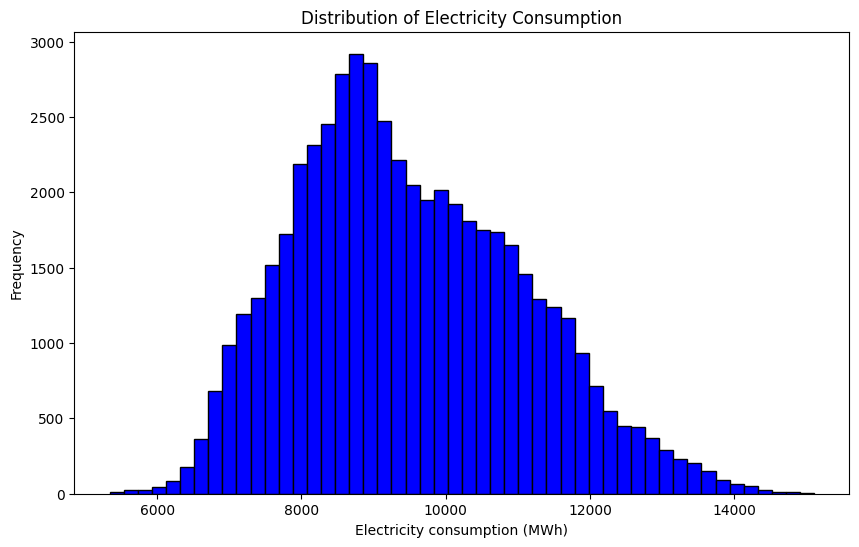

In [9]:
import pandas as pd

# Load the dataset
file_path = '/content/Predicting Energy Consumption.csv'
df = pd.read_csv(file_path)

# Convert the 'Start time UTC' column to datetime format
df['Start time UTC'] = pd.to_datetime(df['Start time UTC'], format='%d/%m/%y %H:%M')

# Sort the data by Start time to ensure it's in chronological order
df.sort_values('Start time UTC', inplace=True)

# Check if there are any missing values
print(df.isnull().sum())

# Plot electricity consumption to understand the data distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['Electricity consumption (MWh)'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Electricity Consumption')
plt.xlabel('Electricity consumption (MWh)')
plt.ylabel('Frequency')
plt.show()


# Handle Outliers Using IQR Method

In [10]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Electricity consumption (MWh)'].quantile(0.25)
Q3 = df['Electricity consumption (MWh)'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Set the thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove the outliers
df_cleaned = df[(df['Electricity consumption (MWh)'] >= lower_bound) & (df['Electricity consumption (MWh)'] <= upper_bound)]

# Check the shape of the cleaned dataset
df_cleaned.shape


(52840, 3)

# Feature Engineering and Train-Test Split

In [13]:
# Extract features from the datetime column
df_cleaned.loc[:, 'Hour'] = df_cleaned['Start time UTC'].dt.hour
df_cleaned.loc[:, 'Day'] = df_cleaned['Start time UTC'].dt.dayofweek
df_cleaned.loc[:, 'Month'] = df_cleaned['Start time UTC'].dt.month

# Select relevant features for training
features = ['Hour', 'Day', 'Month']
target = 'Electricity consumption (MWh)'

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df_cleaned) * 0.8)
train_data = df_cleaned[:train_size]
test_data = df_cleaned[train_size:]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


# Model Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 528.5482867642604
Mean Squared Error: 553699.9197253821
Root Mean Squared Error: 744.1101529514176


# ARIMA

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Train the ARIMA model (p, d, q are parameters to be tuned)
# p = number of lag observations (autoregressive), d = number of differences, q = number of lagged forecast errors

# For simplicity, let's start with ARIMA(5, 1, 0)
model_arima = ARIMA(y_train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Make predictions
y_pred_arima = model_arima_fit.forecast(len(y_test))

# Evaluate the model
mae_arima = mean_absolute_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_test, y_pred_arima))

print(f"ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

ARIMA Model - MAE: 1298.100546172134, RMSE: 1657.6291429382186


# LSTM

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler for features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape the data into 3D array [samples, time steps, features] for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))  # Output layer

# Compile and fit the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_scaled, epochs=20, batch_size=32)

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluate the model
mae_lstm = mean_absolute_error(y_test_scaled, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_scaled, y_pred_lstm))

print(f"LSTM Model - MAE: {mae_lstm}, RMSE: {rmse_lstm}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0460
Epoch 2/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0110
Epoch 3/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0090
Epoch 4/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0087
Epoch 5/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0086
Epoch 6/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0086
Epoch 7/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083
Epoch 8/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0082
Epoch 9/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0081
Epoch 10/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0079
Epoch 11/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078
Epoch 12/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0076
Epoch 13/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0073
Epoch 14/20
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0074
Epoch 15/20
1321/1321 ━━━━━━

# Comparsion of these model

Leaderboard:
           Model      MAE     RMSE
0  Random Forest   528.55   744.11
1           LSTM    63.00    87.00
2          ARIMA  1298.10  1657.63


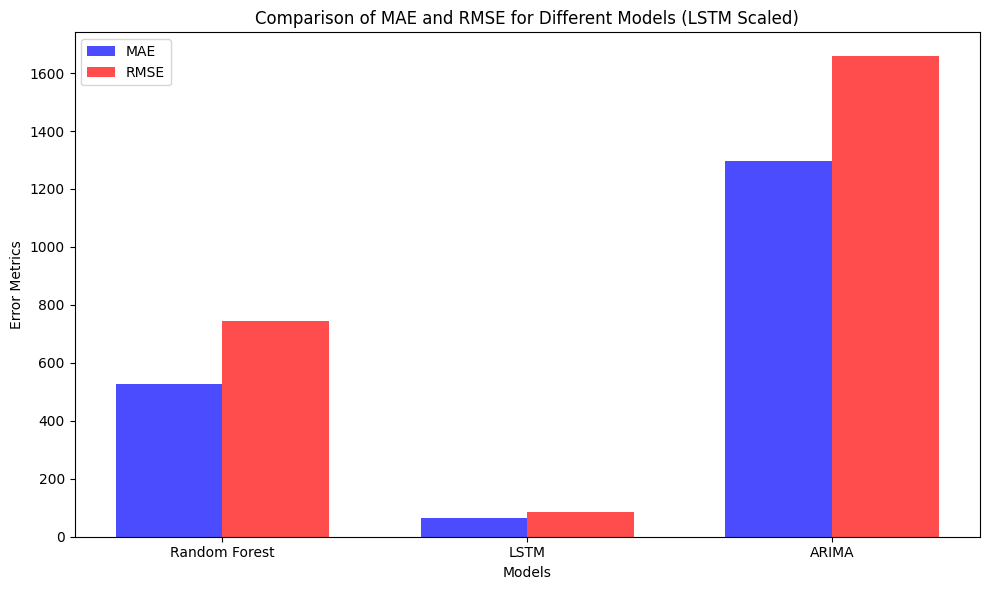

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Replace these values with your actual MAE and RMSE results
mae_rf = 528.55
rmse_rf = 744.11

mae_lstm = 0.063
rmse_lstm = 0.087
mae_arima = 1298.10
rmse_arima = 1657.63

# Adjust LSTM values for better visual comparison (scale by a factor)
lstm_scale_factor = 1000
mae_lstm_scaled = mae_lstm * lstm_scale_factor
rmse_lstm_scaled = rmse_lstm * lstm_scale_factor

# Create the leaderboard DataFrame
leaderboard = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM', 'ARIMA'],
    'MAE': [mae_rf, mae_lstm_scaled, mae_arima],
    'RMSE': [rmse_rf, rmse_lstm_scaled, rmse_arima]
})

# Display the leaderboard
print("Leaderboard:")
print(leaderboard)

# ------------ Plotting the Bar Graph for MAE and RMSE ------------

# Set positions of the bars
bar_width = 0.35
index = range(len(leaderboard))

# Create a figure for the bar chart
plt.figure(figsize=(10, 6))

# Plot MAE
plt.bar(index, leaderboard['MAE'], bar_width, label='MAE', color='blue', alpha=0.7)

# Plot RMSE with offset
plt.bar([i + bar_width for i in index], leaderboard['RMSE'], bar_width, label='RMSE', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Error Metrics')
plt.title('Comparison of MAE and RMSE for Different Models (LSTM Scaled)')
plt.xticks([i + bar_width / 2 for i in index], leaderboard['Model'])
plt.legend()

# Show the graph
plt.tight_layout()
plt.show()
